In [1]:
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/maggot_models')
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/graspy')

In [3]:
import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson

from graspy.embed import OmnibusEmbed, selectSVD
from graspy.match import GraphMatch
from graspy.models import DCSBMEstimator, SBMEstimator
from graspy.utils import (
    augment_diagonal,
    binarize,
    pass_to_ranks,
    remove_loops,
    to_laplace,
)
#from src.cluster import BinaryCluster
from src.data import load_metagraph
from src.graph import MetaGraph
from src.hierarchy import signal_flow
from src.io import savecsv, savefig
from src.utils import get_paired_inds
from src.visualization import (
    CLASS_COLOR_DICT,
    add_connections,
    adjplot,
    plot_color_labels,
    plot_double_dendrogram,
    plot_single_dendrogram,
)

/Users/asaadeldin/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/asaadeldin/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


C++ implementation protocol buffer has overall performance, seehttps://github.com/google/protobuf/blob/master/python/README.md


In [38]:
def aLAP(cost_matrix, maximize = True):
    if not maximize:
        cost_matrix = -cost_matrix
    num_vert = cost_matrix.shape[0]
    n = 2 * num_vert
    matched = np.empty(n)*np.nan
    cv = np.zeros(n)
    qn = np.zeros(n)
    col_argmax = np.argmax(cost_matrix, axis = 0)
    row_argmax = np.argmax(cost_matrix, axis = 1)
    
    # remove full zero rows and columns (match them)
    col_z = np.count_nonzero(cost_matrix, axis = 0)
    col_z = np.arange(num_vert)[col_z == np.zeros(num_vert)] 
    row_z = np.count_nonzero(cost_matrix, axis = 1)
    row_z = np.arange(num_vert)[row_z == np.zeros(num_vert)]
    mz = min([len(row_z), len(col_z)])
    col_z = col_z[:mz]
    row_z = row_z[:mz]
    
    cv[:num_vert] = col_argmax + num_vert  #first half points to second, vice versa
    cv[num_vert:] = row_argmax
    cv[col_z] = row_z + num_vert
    cv[row_z + num_vert] = col_z
    cv = cv.astype(int)
    

    dom_ind = (cv[cv] == np.arange(n))
    matched[dom_ind] = cv[dom_ind] #matched indices, everywhere else nan
    qc, = np.nonzero(dom_ind) #dominating vertices
    

    while len(qc) > 0 and np.isnan(matched).any(): #loop while qc not empty, ie new matchings still being found
        
        temp = np.arange(n)[np.in1d(cv,qc)] #indices of qc in cv
        qt = temp[~np.in1d(temp, matched[qc])] #indices of unmatched verts in cv and qc
        
        qt_p = qt[qt>=num_vert]
        qt_n = qt[qt< num_vert]
        
        m_row = np.arange(num_vert)[np.isnan(matched[num_vert:])] #unmatched rows to check
        m_col = np.arange(num_vert)[np.isnan(matched[:num_vert])]  #unmatched cols
            
        col_argmax = np.argmax(cost_matrix[np.ix_(m_row, qt_n)], axis = 0)
        row_argmax = np.argmax(cost_matrix[np.ix_(qt_p - num_vert, m_col)] , axis = 1)
        
        col_argmax = m_row[col_argmax]
        row_argmax = m_col[row_argmax]
        
        cv[qt_n] = col_argmax + num_vert
        cv[qt_p] = row_argmax
        cv = cv.astype(int)
        
        dom_ind = (cv[cv[qt]] == qt)
        qt = qt[dom_ind]
        matched[qt] = cv[qt] #adding new dominating indices to matching
        matched[cv[qt]] = qt
        #mate[dom_ind] = cv[dom_ind]
        
        qn = np.zeros(n)  #store new matchings
        qn[qt] = qt
        qn[cv[qt]] = cv[qt]
        qc = qn[qn>0].astype(int)
        
    matching = matched[num_vert:]
    rows = np.arange(num_vert)[~np.isnan(matching)]
    matching = matching[~np.isnan(matching)].astype(int)
    return (rows, matching)

In [349]:
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, minimize_scalar, OptimizeResult

def quadratic_assignment_aLAP(
    cost_matrix,
    dist_matrix,
    maximize=False,
    options=None
):

    if options is None:
        options = {}

    return _quadratic_assignment_faq(cost_matrix, dist_matrix, maximize,
                                     **options)


def _quadratic_assignment_faq(
        cost_matrix,
        dist_matrix,
        maximize=False,
        partial_match=None,
        init="barycenter",
        init_weight=None,
        init_n=1,
        maxiter=30,
        shuffle_input=True,
        eps=0.05
):

    cost_matrix = np.asarray(cost_matrix)
    dist_matrix = np.asarray(dist_matrix)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.asarray(partial_match)
    init_n = operator.index(init_n)
    maxiter = operator.index(maxiter)

    # ValueError check
    msg = None
    if cost_matrix.shape[0] != cost_matrix.shape[1]:
        msg = "'cost_matrix' must be square"
    elif dist_matrix.shape[0] != dist_matrix.shape[1]:
        msg = "'dist_matrix' must be square"
    elif cost_matrix.shape != dist_matrix.shape:
        msg = "Adjacency matrices must be of equal size"
    elif (cost_matrix < 0).any() or (dist_matrix < 0).any():
        msg = "Adjacency matrix contains negative entries"
    elif partial_match.shape[0] > cost_matrix.shape[0]:
        msg = "There cannot be more seeds than there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif (partial_match < 0).any():
        msg = "`partial_match` contains negative entries"
    elif (partial_match >= len(cost_matrix)).any():
        msg = "`partial_match` entries must be less than the number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not \
            len(set(partial_match[:, 1])) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"
    elif isinstance(init, str) and init not in {'barycenter'}:
        msg = "Invalid 'init' parameter string"
    elif init_weight is not None and (init_weight < 0 or init_weight > 1):
        msg = "'init_weight' must be in range [0, 1]"
    elif init_n <= 0:
        msg = "'n_init' must be a positive integer"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    if msg is not None:
        raise ValueError(msg)

    # TypeError check
    if type(shuffle_input) is not bool:
        msg = "'shuffle_input' must be a boolean"
    elif eps <= 0 or type(eps) is not float:
        msg = "'eps' must be a positive float"
    elif type(maximize) is not bool:
        msg = "'maximize' must be a boolean"
    if msg is not None:
        raise TypeError(msg)

    rng = np.random.RandomState()
    n = cost_matrix.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    perm_inds = np.zeros(n)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1
    score = obj_func_scalar * np.inf

    seed_dist_c = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        seed_dist_c = rng.permutation(seed_dist_c)
        # shuffle_input to avoid results from inputs that were already matched

    seed_cost_c = np.setdiff1d(range(n), partial_match[:, 0])
    permutation_cost = np.concatenate([partial_match[:, 0],
                                       seed_cost_c], axis=None).astype(int)
    permutation_dist = np.concatenate([partial_match[:, 1],
                                       seed_dist_c], axis=None).astype(int)
    cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
    dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

    # definitions according to Seeded Graph Matching [2].
    A11 = cost_matrix[:n_seeds, :n_seeds]
    A12 = cost_matrix[:n_seeds, n_seeds:]
    A21 = cost_matrix[n_seeds:, :n_seeds]
    A22 = cost_matrix[n_seeds:, n_seeds:]
    B11 = dist_matrix[:n_seeds, :n_seeds]
    B12 = dist_matrix[:n_seeds, n_seeds:]
    B21 = dist_matrix[n_seeds:, :n_seeds]
    B22 = dist_matrix[n_seeds:, n_seeds:]

    for i in range(init_n):
        # setting initialization matrix
        if isinstance(init, str) and init == 'barycenter':
            J = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        else:
            _check_init_input(init, n_unseed)
            J = init
        if init_weight is not None:
            # generate a nxn matrix where each entry is a random number [0, 1]
            K = rng.rand(n_unseed, n_unseed)
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            # initialize J, a doubly stochastic barycenter
            P = J * init_weight + (1 - init_weight) * K
        else:
            P = J
        const_sum = A21 @ B21.T + A12.T @ B12
        grad_P = np.inf  # gradient of P
        grad_s = np.inf
        n_iter = 0  # number of FW iterations
        score = np.zeros(maxiter+2)
        times = np.zeros(maxiter+2)
        start = time.time()
        # OPTIMIZATION WHILE LOOP BEGINS
        while grad_P > eps and n_iter < maxiter and grad_s > 0.001:
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            #rows, cols = aLAP(delta_f, maximize)
            rows, cols = aLAP(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            score_new = np.trace(cost_matrix @ P @ dist_matrix.T @ P.T)
            n_iter += 1
            score[n_iter] = score_new
            times[n_iter] = time.time() - start
            grad_s = abs(score[n_iter] - score[n_iter-1])/score[n_iter]
        row, col = aLAP(
            P
        )  # Project onto the set of permutation matrices

        perm_inds_new = np.concatenate(
            (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
        ).astype(int)

        score_new = np.trace(
            np.transpose(cost_matrix)
            @ dist_matrix[np.ix_(perm_inds_new, perm_inds_new)]
        )  # computing objective function value

        score[n_iter] = score_new
        times[n_iter] = time.time() - start
#         if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
#             score = score_new
#             perm_inds = np.zeros(n, dtype=int)
#             perm_inds[permutation_cost] = permutation_dist[perm_inds_new]

    perm_inds = np.zeros(n, dtype=int)
    perm_inds[permutation_cost] = permutation_dist[perm_inds_new]
    permutation_cost_inv = np.argsort(permutation_cost)
    cost_matrix = cost_matrix[
        np.ix_(permutation_cost_inv, permutation_cost_inv)
    ]
    permutation_dist_inv = np.argsort(permutation_dist)
    dist_matrix = dist_matrix[
        np.ix_(permutation_dist_inv, permutation_dist_inv)
    ]

#     score = np.trace(
#         np.transpose(cost_matrix) @ dist_matrix[np.ix_(perm_inds, perm_inds)]
#     )

    res = {"col_ind": perm_inds, "score": score, "nit": n_iter, "times": times}

    return OptimizeResult(res)


def _check_init_input(init, n):
    row_sum = np.round(np.sum(init, axis=0), decimals=2)
    col_sum = np.round(np.sum(init, axis=1), decimals=2)
    msg = None
    if init.shape != (n, n):
        msg = "`init` matrix must have same shape as A and B"
    elif (row_sum != 1.).any() or (col_sum != 1.).any() or (init < 0).any():
        msg = "`init` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _doubly_stochastic(P, eps=1e-3):
    # cleaner implementation of btaba/sinkhorn_knopp
    # Title: sinkhorn_knopp Source Code
    # Author: Tabanpour, B
    # Date: 2018
    # Code version:  0.2
    # Availability: https://pypi.org/project/sinkhorn_knopp/
    #

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < eps).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < eps).all()):
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps


In [279]:
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, minimize_scalar, OptimizeResult

def quadratic_assignment_atoLAP(
    cost_matrix,
    dist_matrix,
    maximize=False,
    options=None
):

    if options is None:
        options = {}

    return _quadratic_assignment_faq(cost_matrix, dist_matrix, maximize,
                                     **options)


def _quadratic_assignment_faq(
        cost_matrix,
        dist_matrix,
        maximize=False,
        partial_match=None,
        init="barycenter",
        init_weight=None,
        init_n=1,
        maxiter=30,
        shuffle_input=True,
        eps=0.05
):

    cost_matrix = np.asarray(cost_matrix)
    dist_matrix = np.asarray(dist_matrix)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.asarray(partial_match)
    init_n = operator.index(init_n)
    maxiter = operator.index(maxiter)

    # ValueError check
    msg = None
    if cost_matrix.shape[0] != cost_matrix.shape[1]:
        msg = "'cost_matrix' must be square"
    elif dist_matrix.shape[0] != dist_matrix.shape[1]:
        msg = "'dist_matrix' must be square"
    elif cost_matrix.shape != dist_matrix.shape:
        msg = "Adjacency matrices must be of equal size"
    elif (cost_matrix < 0).any() or (dist_matrix < 0).any():
        msg = "Adjacency matrix contains negative entries"
    elif partial_match.shape[0] > cost_matrix.shape[0]:
        msg = "There cannot be more seeds than there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif (partial_match < 0).any():
        msg = "`partial_match` contains negative entries"
    elif (partial_match >= len(cost_matrix)).any():
        msg = "`partial_match` entries must be less than the number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not \
            len(set(partial_match[:, 1])) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"
    elif isinstance(init, str) and init not in {'barycenter'}:
        msg = "Invalid 'init' parameter string"
    elif init_weight is not None and (init_weight < 0 or init_weight > 1):
        msg = "'init_weight' must be in range [0, 1]"
    elif init_n <= 0:
        msg = "'n_init' must be a positive integer"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    if msg is not None:
        raise ValueError(msg)

    # TypeError check
    if type(shuffle_input) is not bool:
        msg = "'shuffle_input' must be a boolean"
    elif eps <= 0 or type(eps) is not float:
        msg = "'eps' must be a positive float"
    elif type(maximize) is not bool:
        msg = "'maximize' must be a boolean"
    if msg is not None:
        raise TypeError(msg)

    rng = np.random.RandomState()
    n = cost_matrix.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    perm_inds = np.zeros(n)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1
    score = obj_func_scalar * np.inf

    seed_dist_c = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        seed_dist_c = rng.permutation(seed_dist_c)
        # shuffle_input to avoid results from inputs that were already matched

    seed_cost_c = np.setdiff1d(range(n), partial_match[:, 0])
    permutation_cost = np.concatenate([partial_match[:, 0],
                                       seed_cost_c], axis=None).astype(int)
    permutation_dist = np.concatenate([partial_match[:, 1],
                                       seed_dist_c], axis=None).astype(int)
    cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
    dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

    # definitions according to Seeded Graph Matching [2].
    A11 = cost_matrix[:n_seeds, :n_seeds]
    A12 = cost_matrix[:n_seeds, n_seeds:]
    A21 = cost_matrix[n_seeds:, :n_seeds]
    A22 = cost_matrix[n_seeds:, n_seeds:]
    B11 = dist_matrix[:n_seeds, :n_seeds]
    B12 = dist_matrix[:n_seeds, n_seeds:]
    B21 = dist_matrix[n_seeds:, :n_seeds]
    B22 = dist_matrix[n_seeds:, n_seeds:]

    for i in range(init_n):
        # setting initialization matrix
        if isinstance(init, str) and init == 'barycenter':
            J = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        else:
            _check_init_input(init, n_unseed)
            J = init
        if init_weight is not None:
            # generate a nxn matrix where each entry is a random number [0, 1]
            K = rng.rand(n_unseed, n_unseed)
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            # initialize J, a doubly stochastic barycenter
            P = J * init_weight + (1 - init_weight) * K
        else:
            P = J
        const_sum = A21 @ B21.T + A12.T @ B12
        grad_P = np.inf  # gradient of P
        n_iter = 0  # number of FW iterations
        score = np.zeros(maxiter+2)
        times = np.zeros(maxiter+2)
        start = time.time()
        # OPTIMIZATION WHILE LOOP BEGINS
        while grad_P > eps and n_iter < (maxiter/2):
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            #rows, cols = aLAP(delta_f, maximize)
            rows, cols = aLAP(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            score_new = np.trace(cost_matrix @ P @ dist_matrix.T @ P.T)
            n_iter += 1
            score[n_iter] = score_new
            times[n_iter] = time.time() - start
        
        grad_P = np.inf
        while grad_P > eps and n_iter < maxiter:
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            #rows, cols = aLAP(delta_f, maximize)
            rows, cols = linear_sum_assignmet(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            score_new = np.trace(cost_matrix @ P @ dist_matrix.T @ P.T)
            n_iter += 1
            score[n_iter] = score_new
            times[n_iter] = time.time() - start
           
        row, col = linear_sum_assignment(
            -P
        )  # Project onto the set of permutation matrices

        perm_inds_new = np.concatenate(
            (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
        ).astype(int)

        score_new = np.trace(
            np.transpose(cost_matrix)
            @ dist_matrix[np.ix_(perm_inds_new, perm_inds_new)]
        )  # computing objective function value

        score[n_iter] = score_new
        times[n_iter] = time.time() - start
#         if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
#             score = score_new
#             perm_inds = np.zeros(n, dtype=int)
#             perm_inds[permutation_cost] = permutation_dist[perm_inds_new]

    perm_inds = np.zeros(n, dtype=int)
    perm_inds[permutation_cost] = permutation_dist[perm_inds_new]
    permutation_cost_inv = np.argsort(permutation_cost)
    cost_matrix = cost_matrix[
        np.ix_(permutation_cost_inv, permutation_cost_inv)
    ]
    permutation_dist_inv = np.argsort(permutation_dist)
    dist_matrix = dist_matrix[
        np.ix_(permutation_dist_inv, permutation_dist_inv)
    ]

#     score = np.trace(
#         np.transpose(cost_matrix) @ dist_matrix[np.ix_(perm_inds, perm_inds)]
#     )

    res = {"col_ind": perm_inds, "score": score, "nit": n_iter, "times": times}

    return OptimizeResult(res)


def _check_init_input(init, n):
    row_sum = np.round(np.sum(init, axis=0), decimals=2)
    col_sum = np.round(np.sum(init, axis=1), decimals=2)
    msg = None
    if init.shape != (n, n):
        msg = "`init` matrix must have same shape as A and B"
    elif (row_sum != 1.).any() or (col_sum != 1.).any() or (init < 0).any():
        msg = "`init` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _doubly_stochastic(P, eps=1e-3):
    # cleaner implementation of btaba/sinkhorn_knopp
    # Title: sinkhorn_knopp Source Code
    # Author: Tabanpour, B
    # Date: 2018
    # Code version:  0.2
    # Availability: https://pypi.org/project/sinkhorn_knopp/
    #

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < eps).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < eps).all()):
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps


In [280]:
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, minimize_scalar, OptimizeResult

def quadratic_assignment_LAP(
    cost_matrix,
    dist_matrix,
    maximize=False,
    options=None
):

    if options is None:
        options = {}

    return _quadratic_assignment_faq(cost_matrix, dist_matrix, maximize,
                                     **options)


def _quadratic_assignment_faq(
        cost_matrix,
        dist_matrix,
        maximize=False,
        partial_match=None,
        init="barycenter",
        init_weight=None,
        init_n=1,
        maxiter=30,
        shuffle_input=True,
        eps=0.05
):

    cost_matrix = np.asarray(cost_matrix)
    dist_matrix = np.asarray(dist_matrix)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.asarray(partial_match)
    init_n = operator.index(init_n)
    maxiter = operator.index(maxiter)

    # ValueError check
    msg = None
    if cost_matrix.shape[0] != cost_matrix.shape[1]:
        msg = "'cost_matrix' must be square"
    elif dist_matrix.shape[0] != dist_matrix.shape[1]:
        msg = "'dist_matrix' must be square"
    elif cost_matrix.shape != dist_matrix.shape:
        msg = "Adjacency matrices must be of equal size"
    elif (cost_matrix < 0).any() or (dist_matrix < 0).any():
        msg = "Adjacency matrix contains negative entries"
    elif partial_match.shape[0] > cost_matrix.shape[0]:
        msg = "There cannot be more seeds than there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif (partial_match < 0).any():
        msg = "`partial_match` contains negative entries"
    elif (partial_match >= len(cost_matrix)).any():
        msg = "`partial_match` entries must be less than the number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not \
            len(set(partial_match[:, 1])) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"
    elif isinstance(init, str) and init not in {'barycenter'}:
        msg = "Invalid 'init' parameter string"
    elif init_weight is not None and (init_weight < 0 or init_weight > 1):
        msg = "'init_weight' must be in range [0, 1]"
    elif init_n <= 0:
        msg = "'n_init' must be a positive integer"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    if msg is not None:
        raise ValueError(msg)

    # TypeError check
    if type(shuffle_input) is not bool:
        msg = "'shuffle_input' must be a boolean"
    elif eps <= 0 or type(eps) is not float:
        msg = "'eps' must be a positive float"
    elif type(maximize) is not bool:
        msg = "'maximize' must be a boolean"
    if msg is not None:
        raise TypeError(msg)

    rng = np.random.RandomState()
    n = cost_matrix.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    perm_inds = np.zeros(n)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1
    score = obj_func_scalar * np.inf

    seed_dist_c = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        seed_dist_c = rng.permutation(seed_dist_c)
        # shuffle_input to avoid results from inputs that were already matched

    seed_cost_c = np.setdiff1d(range(n), partial_match[:, 0])
    permutation_cost = np.concatenate([partial_match[:, 0],
                                       seed_cost_c], axis=None).astype(int)
    permutation_dist = np.concatenate([partial_match[:, 1],
                                       seed_dist_c], axis=None).astype(int)
    cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
    dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

    # definitions according to Seeded Graph Matching [2].
    A11 = cost_matrix[:n_seeds, :n_seeds]
    A12 = cost_matrix[:n_seeds, n_seeds:]
    A21 = cost_matrix[n_seeds:, :n_seeds]
    A22 = cost_matrix[n_seeds:, n_seeds:]
    B11 = dist_matrix[:n_seeds, :n_seeds]
    B12 = dist_matrix[:n_seeds, n_seeds:]
    B21 = dist_matrix[n_seeds:, :n_seeds]
    B22 = dist_matrix[n_seeds:, n_seeds:]

    for i in range(init_n):
        # setting initialization matrix
        if isinstance(init, str) and init == 'barycenter':
            J = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        else:
            _check_init_input(init, n_unseed)
            J = init
        if init_weight is not None:
            # generate a nxn matrix where each entry is a random number [0, 1]
            K = rng.rand(n_unseed, n_unseed)
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            # initialize J, a doubly stochastic barycenter
            P = J * init_weight + (1 - init_weight) * K
        else:
            P = J
        const_sum = A21 @ B21.T + A12.T @ B12
        grad_P = np.inf  # gradient of P
        n_iter = 0  # number of FW iterations
        score = np.zeros(maxiter+2)
        times = np.zeros(maxiter+2)
        start = time.time()
        # OPTIMIZATION WHILE LOOP BEGINS
     
        while grad_P > eps and n_iter < maxiter:
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            #rows, cols = aLAP(delta_f, maximize)
            rows, cols = linear_sum_assignment(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            score_new = np.trace(cost_matrix @ P @ dist_matrix.T @ P.T)
            n_iter += 1
            score[n_iter] = score_new
            times[n_iter] = time.time() - start
        # end of FW optimization loop
        
        row, col = linear_sum_assignment(
            -P
        )  # Project onto the set of permutation matrices

        perm_inds_new = np.concatenate(
            (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
        ).astype(int)

        score_new = np.trace(
            np.transpose(cost_matrix)
            @ dist_matrix[np.ix_(perm_inds_new, perm_inds_new)]
        )  # computing objective function value

        score[n_iter] = score_new
        times[n_iter] = time.time() - start
#         if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
#             score = score_new
#             perm_inds = np.zeros(n, dtype=int)
#             perm_inds[permutation_cost] = permutation_dist[perm_inds_new]

    perm_inds = np.zeros(n, dtype=int)
    perm_inds[permutation_cost] = permutation_dist[perm_inds_new]
    permutation_cost_inv = np.argsort(permutation_cost)
    cost_matrix = cost_matrix[
        np.ix_(permutation_cost_inv, permutation_cost_inv)
    ]
    permutation_dist_inv = np.argsort(permutation_dist)
    dist_matrix = dist_matrix[
        np.ix_(permutation_dist_inv, permutation_dist_inv)
    ]

#     score = np.trace(
#         np.transpose(cost_matrix) @ dist_matrix[np.ix_(perm_inds, perm_inds)]
#     )

    res = {"col_ind": perm_inds, "score": score, "nit": n_iter, "times": times}

    return OptimizeResult(res)


def _check_init_input(init, n):
    row_sum = np.round(np.sum(init, axis=0), decimals=2)
    col_sum = np.round(np.sum(init, axis=1), decimals=2)
    msg = None
    if init.shape != (n, n):
        msg = "`init` matrix must have same shape as A and B"
    elif (row_sum != 1.).any() or (col_sum != 1.).any() or (init < 0).any():
        msg = "`init` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _doubly_stochastic(P, eps=1e-3):
    # cleaner implementation of btaba/sinkhorn_knopp
    # Title: sinkhorn_knopp Source Code
    # Author: Tabanpour, B
    # Date: 2018
    # Code version:  0.2
    # Availability: https://pypi.org/project/sinkhorn_knopp/
    #

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < eps).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < eps).all()):
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps


In [4]:
mg = load_metagraph('G', path = '',version='')

In [6]:
graph_type = "G"
VERSION = ""

master_mg = load_metagraph(graph_type, path = '', version=VERSION)
mg = MetaGraph(master_mg.adj, master_mg.meta)
mg = mg.remove_pdiff()
meta = mg.meta.copy()

# remove low degree neurons
degrees = mg.calculate_degrees()
quant_val = np.quantile(degrees["Total edgesum"], 0.05)
idx = meta[degrees["Total edgesum"] > quant_val].index
print(quant_val)
mg = mg.reindex(idx, use_ids=True)
mg = mg.make_lcc()
meta = mg.meta

# TODO the following block needs to be cleaned up, should make this easy to do with
# MetaGraph class
temp_meta = meta[meta["left"] | meta["right"]]
unpair_idx = temp_meta[~temp_meta["pair"].isin(temp_meta.index)].index
meta.loc[unpair_idx, ["pair", "pair_id"]] = -1

left_idx = meta[meta["left"]].index
left_mg = MetaGraph(mg.adj, mg.meta)
left_mg = left_mg.reindex(left_idx, use_ids=True)
left_mg = left_mg.sort_values(["pair_id"], ascending=False)
print(len(left_mg))
right_idx = meta[meta["right"]].index
right_mg = MetaGraph(mg.adj, mg.meta)
right_mg = right_mg.reindex(right_idx, use_ids=True)
right_mg = right_mg.sort_values(["pair_id"], ascending=False)
right_mg = right_mg.reindex(right_mg.meta.index[: len(left_mg)], use_ids=True)
print(len(right_mg))



10.0
1410
1410


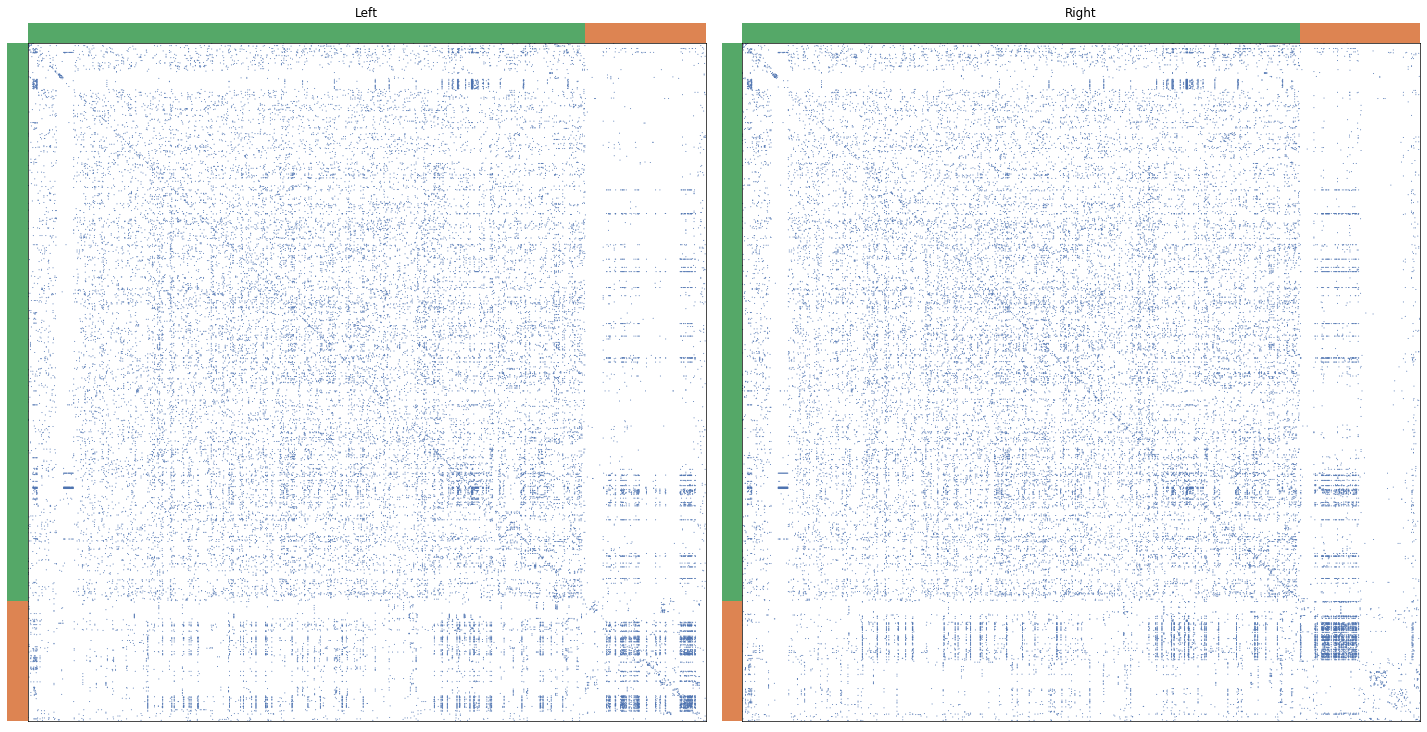

In [7]:
n_pairs = len(right_mg.meta[right_mg.meta["pair_id"] != -1])
left_adj = left_mg.adj
right_adj = right_mg.adj
left_seeds = right_seeds = np.arange(n_pairs)
#currtime = time.time()
#gm = GraphMatch(n_init=50, init_method="rand", eps=1.0, shuffle_input=False)
#gm.fit(left_adj, right_adj, seeds_A=left_seeds, seeds_B=right_seeds)
#print(f"{(time.time() - currtime)/60:0.2f} minutes elapsed for graph matching")

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
#perm_inds = gm.perm_inds_
true_pairs = n_pairs * ["paired"] + (len(left_adj) - n_pairs) * ["unpaired"]
pal = sns.color_palette("deep", 3)
color_dict = dict(zip(["unpaired", "paired"], pal[1:]))
_, _, top, _ = adjplot(
    left_adj,
    ax=axs[0],
    plot_type="scattermap",
    sizes=(1, 1),
    colors=true_pairs,
    palette=color_dict,
    color=pal[0],
    ticks=True,
)
top.set_title("Left")
_, _, top, _ = adjplot(
    right_adj,
    ax=axs[1],
    plot_type="scattermap",
    sizes=(1, 1),
    colors=true_pairs,
    palette=color_dict,
    color=pal[0],
    ticks=True,
)
top.set_title("Right")
plt.tight_layout()
#stashfig("gm-results-adj")


In [2]:
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment


In [23]:
row_perm = np.random.permutation(right_adj.shape[0])
right_shuff = right_adj[np.ix_(row_perm, np.arange(right_adj.shape[0]))]

In [49]:
import time
start = time.time()
res = quadratic_assignment(left_adj,right_adj, maximize=True, options={"eps": 1.0})
time.time()-start

102.92568182945251

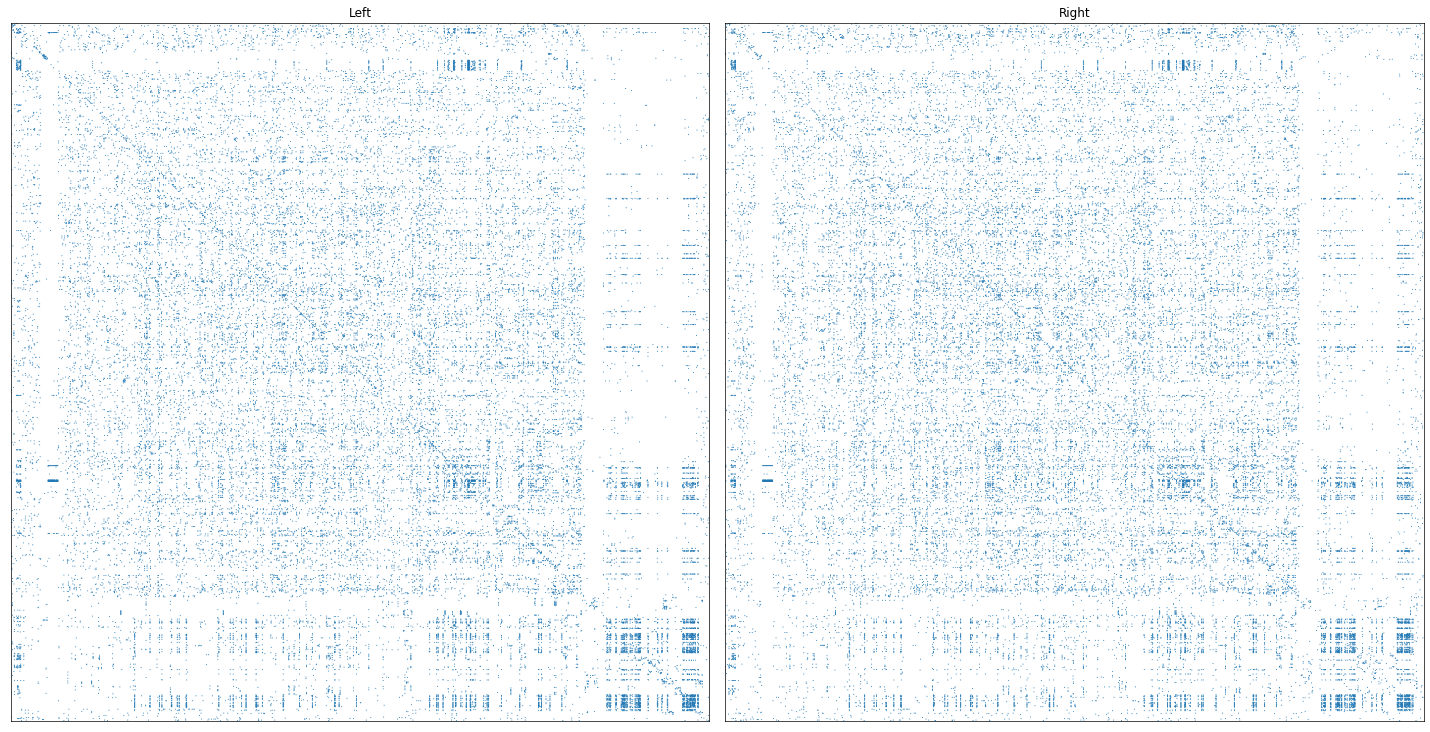

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
perm_inds = res['col_ind']
color_dict = dict(zip(["unpaired", "paired"], pal[1:]))
_, _, top, _ = adjplot(
    left_adj,
    ax=axs[0],
    plot_type="scattermap",
    sizes=(1, 1),
    ticks=True,
)
top.set_title("Left")
_, _, top, _ = adjplot(
    right_adj[np.ix_(perm_inds,perm_inds)],
    ax=axs[1],
    plot_type="scattermap",
    sizes=(1, 1),
    ticks=True,
)
top.set_title("Right")
plt.tight_layout()
plt.savefig('maggot_gm_noseeds')

In [69]:
np.sum(perm_inds[:n_pairs] == np.arange(n_pairs))/n_pairs

0.7743324720068906

In [139]:
import time
start = time.time()
res2 = quadratic_assignment_aLAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})
time.time()-start

65.05885314941406

In [141]:
res2['nit']

30

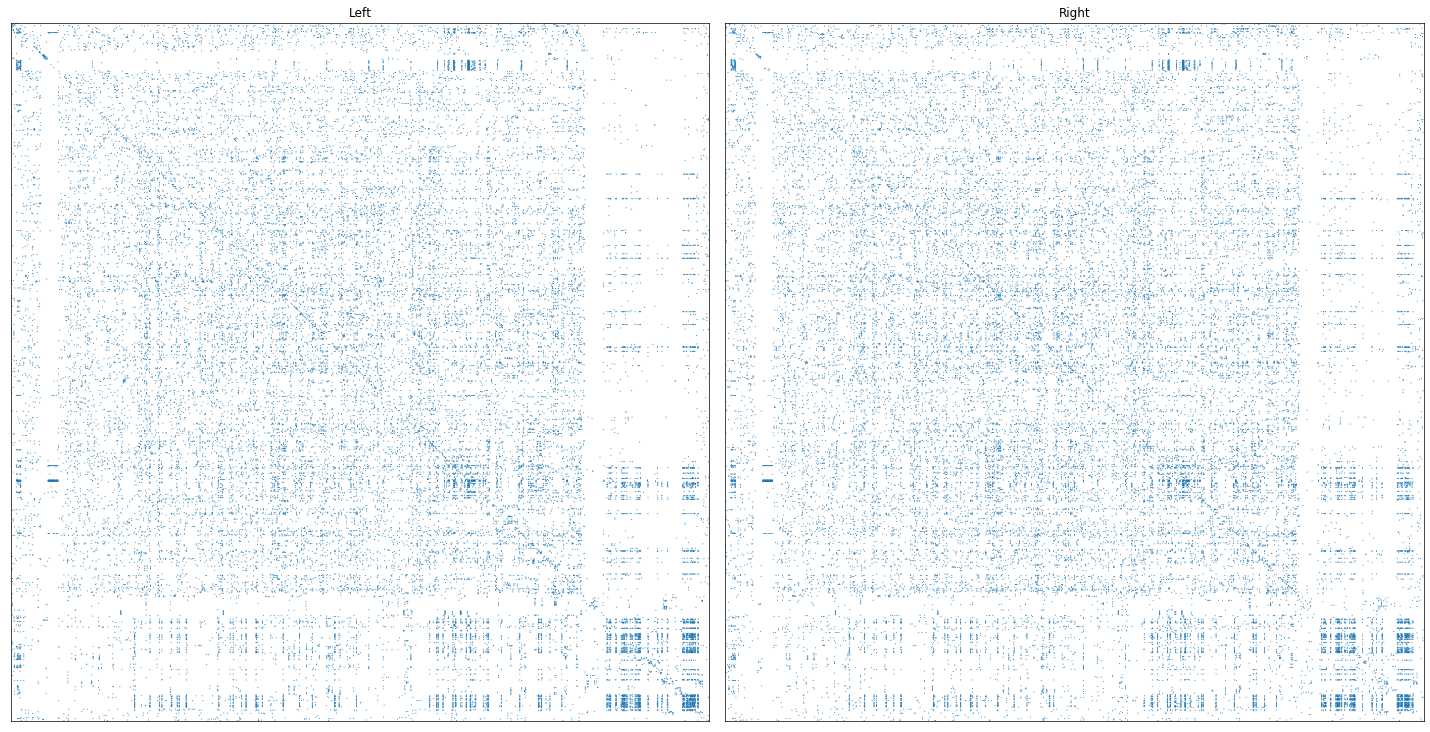

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
perm_inds = res2['col_ind']
color_dict = dict(zip(["unpaired", "paired"], pal[1:]))
_, _, top, _ = adjplot(
    left_adj,
    ax=axs[0],
    plot_type="scattermap",
    sizes=(1, 1),
    ticks=True,
)
top.set_title("Left")
_, _, top, _ = adjplot(
    right_adj[np.ix_(perm_inds,perm_inds)],
    ax=axs[1],
    plot_type="scattermap",
    sizes=(1, 1),
    ticks=True,
)
top.set_title("Right")
plt.tight_layout()


In [143]:
np.sum(perm_inds[:n_pairs] == np.arange(n_pairs))/n_pairs

0.67786391042205

In [123]:
import pandas as pd
new = right_mg.meta.filter(['merge_class','pair_id','pair'], axis = 1)

In [104]:
predicted_id = np.array(right_mg.meta['pair_id'])[perm_inds]

In [105]:
predicted_id

array([1185,  462, 1182, ..., 1104,  670,   -1])

In [125]:
new.insert(2, "predicted pair_id", predicted_id, True)
new.insert(4, "predicted pair", np.array(left_mg.meta.index)[perm_inds], True)


In [126]:
new.insert(5,"pair merge_class", np.array(left_mg.meta['merge_class']))
new.insert(6,"predicted pair merge_class", np.array(left_mg.meta['merge_class'])[perm_inds])

In [128]:
new.to_csv('matched_metadata.csv')

In [291]:
reps = 15
alap_t = np.zeros((reps,32))
alap_s = np.zeros((reps,32))
alap_ac = np.zeros(reps)

lap_t = np.zeros((reps,32))
lap_s = np.zeros((reps,32))
lap_ac = np.zeros(reps)

atolap_t = np.zeros((reps,32))
atolap_s = np.zeros((reps,32))
atolap_ac = np.zeros(reps)

for i in range(reps):
    res = quadratic_assignment_LAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})
    lap_t[i,:] = res['times']
    lap_s[i,:] = res['score']
    lap_ac[i] = np.sum(res['col_ind'][:n_pairs] == np.arange(n_pairs))/n_pairs
    
    
    res = quadratic_assignment_aLAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})
    alap_t[i,:] = res['times']
    alap_s[i,:] = res['score']
    alap_ac[i] = np.sum(res['col_ind'][:n_pairs] == np.arange(n_pairs))/n_pairs
    
    res = quadratic_assignment_atoLAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})
    atolap_t[i,:] = res['times']
    atolap_s[i,:] = res['score']
    atolap_ac[i] = np.sum(res['col_ind'][:n_pairs] == np.arange(n_pairs))/n_pairs


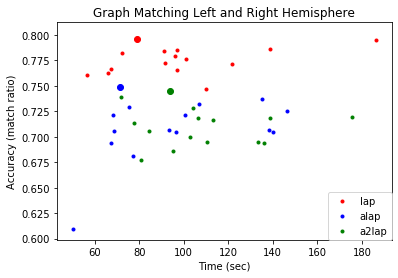

In [181]:
plt.scatter(lap[:,0],lap[:,1], label = 'lap', color = 'red', marker = '.')
plt.scatter(lap[np.argmax(lap[:,1]),0], max(lap[:,1]), color = 'red')
plt.scatter(alap[:,0],alap[:,1], label = 'alap', color = 'blue',marker='.')
plt.scatter(alap[np.argmax(alap[:,1]),0], max(alap[:,1]), color = 'blue')
plt.scatter(atolap[:,0],atolap[:,1], label = 'a2lap', color = 'green', marker = '.')
plt.scatter(atolap[np.argmax(atolap[:,1]),0], max(atolap[:,1]), color = 'green')
plt.xlabel('Time (sec)')
plt.ylabel('Accuracy (match ratio)')
plt.title('Graph Matching Left and Right Hemisphere')

plt.legend(loc="lower right", borderaxespad=0.0)
plt.savefig('maggot_timevsacc')

In [183]:
o_lap = np.copy(lap)
o_alap = np.copy(alap)
o_atolap = np.copy(atolap)

In [185]:
lap

array([[100.94267917,   0.77691645],
       [ 96.89523411,   0.76571921],
       [ 78.98077917,   0.79586563],
       [ 56.44770098,   0.76055125],
       [ 96.97019196,   0.78552972],
       [ 72.42112088,   0.78208441],
       [ 91.77109909,   0.77260982],
       [138.55439901,   0.78639104],
       [121.66203117,   0.77174849],
       [ 67.25011396,   0.76658053],
       [ 91.05190802,   0.78466839],
       [ 66.08373117,   0.76313523],
       [186.53836894,   0.79500431],
       [110.12115002,   0.74677003],
       [ 96.12152505,   0.77950043]])

In [350]:
res = quadratic_assignment_aLAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})


Text(0, 0.5, 'Score')

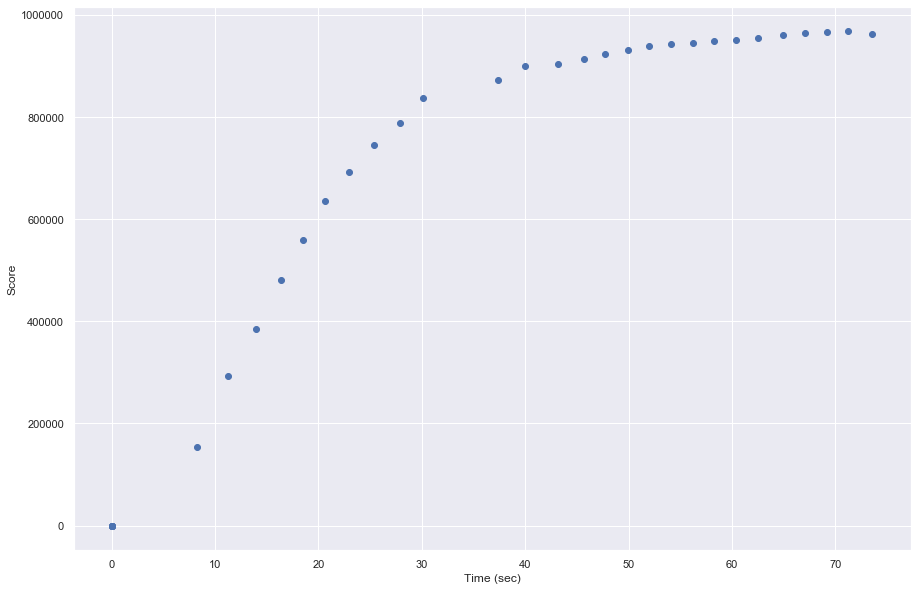

In [351]:
#plt.scatter(np.arange(32), res['score'])
plt.scatter(res['times'], res['score'])
plt.xlabel('Time (sec)')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

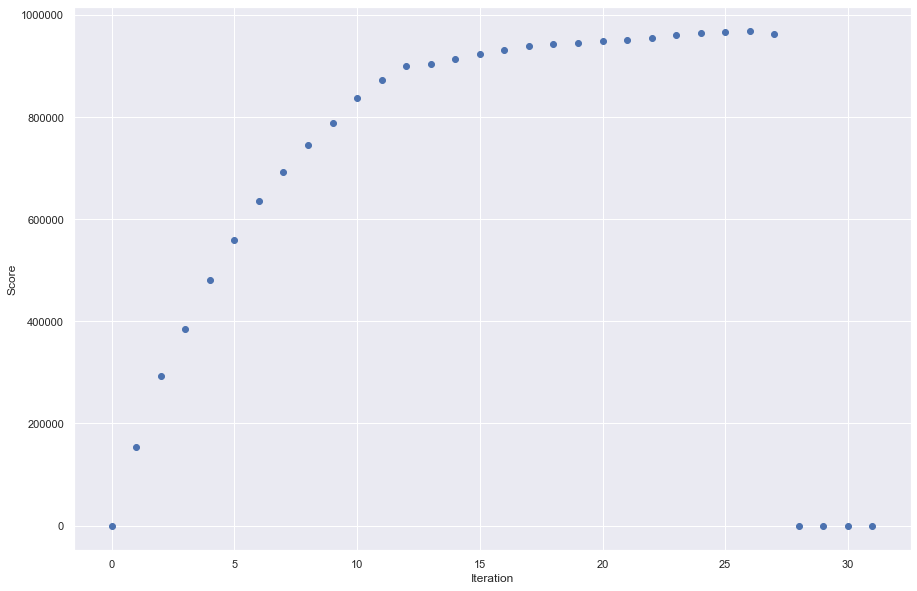

In [352]:
plt.scatter(np.arange(32), res['score'])
#plt.scatter(res['times'], res['score'])
plt.xlabel('Iteration')
plt.ylabel('Score')

In [274]:
res = quadratic_assignment_LAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})

Text(0.5, 1.0, 'LAP')

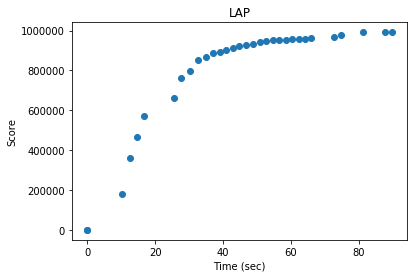

In [287]:
plt.scatter(res['times'], res['score'])
plt.xlabel('Time (sec)')
plt.ylabel('Score')
plt.title('LAP')

Text(0.5, 1.0, 'LAP')

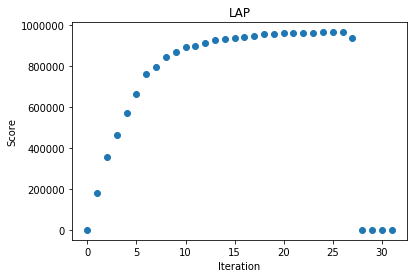

In [276]:
plt.scatter(np.arange(len(res['times'])), res['score'])
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('LAP')

In [281]:
res = quadratic_assignment_atoLAP(left_adj,right_adj, maximize=True, options={"eps": 1.0})

Text(0.5, 1.0, 'a2LAP')

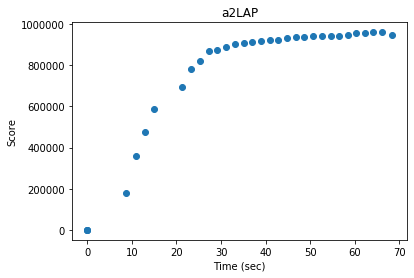

In [282]:
plt.scatter(res['times'], res['score'])
plt.xlabel('Time (sec)')
plt.ylabel('Score')
plt.title('a2LAP')

In [353]:
np.sum(res['col_ind'][:n_pairs] == np.arange(n_pairs))/n_pairs

0.7476313522825151

In [289]:
len(res['score'])

32

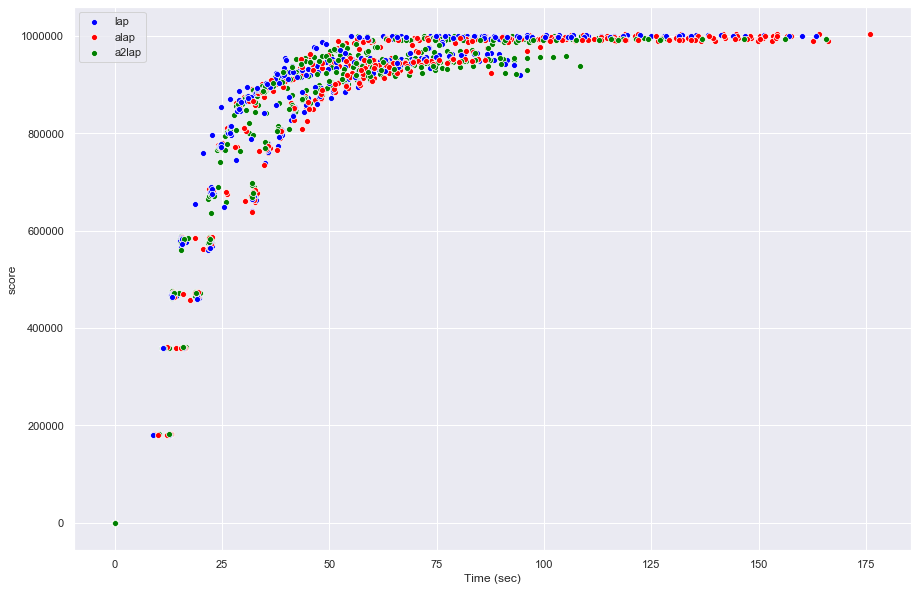

In [317]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

for i in range(reps):
    scatter_kws={'alpha':0.15}
    fig = sns.scatterplot(x=lap_t[i,:], y=lap_s[i,:], legend = 'full' ,  palette = 'pastel', color = 'blue')
    fig = sns.scatterplot(x=alap_t[i,:], y=alap_s[i,:], legend = 'full', color = 'red')
    fig = sns.scatterplot(x=atolap_t[i,:], y=atolap_s[i,:], legend = 'full', color = 'green')
fig.set(xlabel = 'Time (sec)', ylabel = 'score')
plt.legend(labels=['lap', 'alap', 'a2lap'])
plt.savefig('maggot_timevscore')

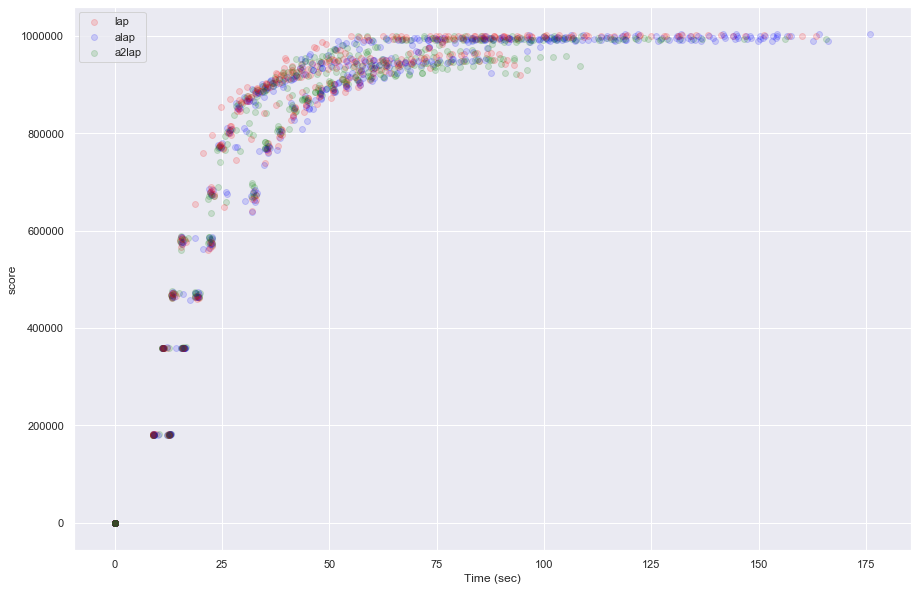

In [323]:
for i in range(reps):
    fig = sns.regplot(x=lap_t[i,:], y=lap_s[i,:], scatter_kws={'alpha':0.15, 'color': 'red'}, fit_reg = False)
    fig = sns.regplot(x=alap_t[i,:], y=alap_s[i,:], scatter_kws={'alpha':0.15, 'color': 'blue'}, fit_reg = False)
    fig = sns.regplot(x=atolap_t[i,:], y=atolap_s[i,:], scatter_kws={'alpha':0.15, 'color': 'green'}, fit_reg = False)
fig.set(xlabel = 'Time (sec)', ylabel = 'score')
plt.legend(labels=['lap', 'alap', 'a2lap'])
plt.savefig('maggot_timevscore')

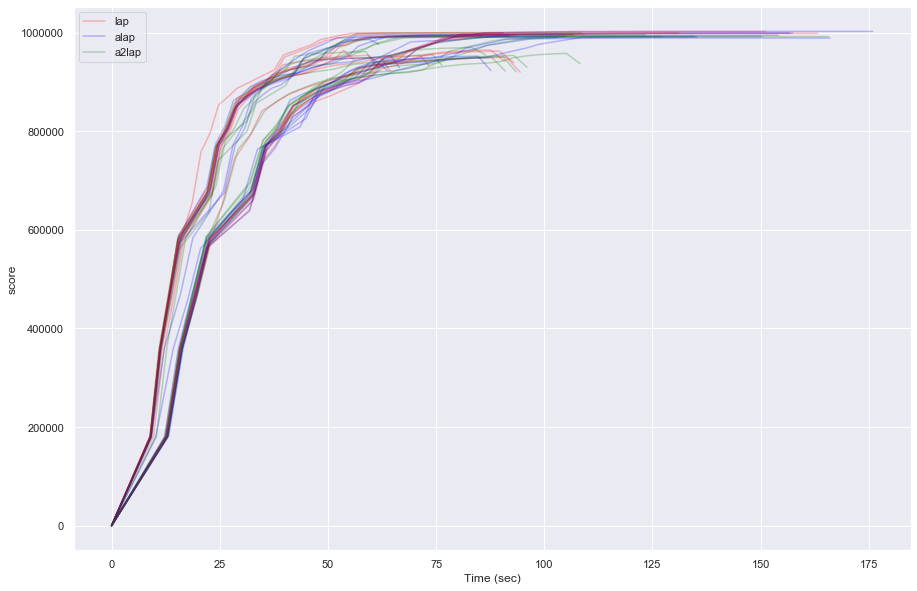

In [341]:
for i in range(reps):
    fig = sns.lineplot(x=lap_t[i,:], y=lap_s[i,:], color = 'red')
    fig = sns.lineplot(x=alap_t[i,:], y=alap_s[i,:], color = 'blue')
    fig = sns.lineplot(x=atolap_t[i,:], y=atolap_s[i,:], color = 'green')
fig.set(xlabel = 'Time (sec)', ylabel = 'score')
#plt.setp(fig.collections, alpha=.1) #for the markers
plt.setp(fig.lines, alpha=.25)
#fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(labels=['lap', 'alap', 'a2lap'])
plt.savefig('maggot_timevscore')